In [1]:
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [6]:
spotify_df = pd.read_csv('spotify_dataset.csv', 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')


In [7]:
spotify_df.describe()

,user_id,artistname,trackname,playlistname
count,12891680,12858112,12891595,12890434
unique,15918,289821,2032044,157504
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,295275,36086,6676,1337085


In [8]:
plays_per_user = pd.DataFrame(
    spotify_df.user_id.value_counts()
).reset_index().rename(columns={'index':'user_id',
                                'user_id':'total_plays'})

In [9]:
top_song = (spotify_df
            .groupby(['artistname','trackname'])
            .agg({'user_id':['count', 'nunique']})
            .sort_values(('user_id','count'), ascending=False)
           )
top_song.columns = ['# of plays',' # of listeners']
top_song.head(20)

,,# of plays,# of listeners
artistname,trackname,,
M83,Midnight City,2609,1890
Daft Punk,Get Lucky - Radio Edit,2341,1836
Imagine Dragons,Radioactive,2336,1815
Of Monsters and Men,Little Talks,2254,1681
Avicii,Wake Me Up,2242,1695
Lorde,Royals,2219,1723
The Lumineers,Ho Hey,2180,1634
Macklemore & Ryan Lewis,Can't Hold Us - feat. Ray Dalton,2066,1583
Bastille,Pompeii,2014,1523


In [48]:
def plot_wordcloud_from_ranking(ranking_dict, max_words=50, plot_title=''):
    
    wc = WordCloud(background_color="black", 
                   max_words=max_words,
                   random_state=1,
                   colormap='gnuplot',
                    )
    wc.generate_from_frequencies(ranking_dict)
    
    plt.title(plot_title, fontsize = 50)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Number of Artists:
289,821

Most played Artist:
Daft Punk - 36,086 plays



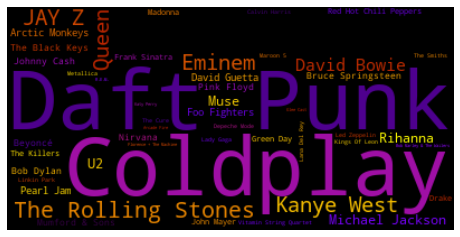

In [49]:
top_artists = pd.DataFrame(spotify_df.artistname.value_counts()).reset_index()
top_artists.columns = ['artistname', 'plays']

top_artists_dict = top_artists.set_index('artistname').to_dict()['plays']


print("Number of Artists:")
print(f'{len(top_artists):,}')
print()

print("Most played Artist:")
print("{0} - {1} plays".format(top_artists.loc[0, 'artistname'], f'{top_artists.loc[0, "plays"]:,}'))
print()

plot_wordcloud_from_ranking(top_artists_dict, max_words=50)

In [19]:
# Names for the x-axis
exp10_series = 10 ** np.array(range(6))
# subtract 1 as we start count at 0
idx = exp10_series - 1

top_artists = spotify_df.groupby('artistname').count().sort_values('user_id', ascending=False)
top_artists = top_artists[['user_id']]
top_artists.columns = ['plays']

artists_popularity = top_artists.copy()
artists_popularity['cumulated_sum'] = artists_popularity['plays'].cumsum()
artists_popularity['share'] = artists_popularity['cumulated_sum'] / artists_popularity['plays'].sum()

artist_plays_dist = (artists_popularity
                     .reset_index()
                     .iloc[idx][['share']]
                     .reset_index()
                     .rename(columns={'index':'rank'})
                    )
artist_plays_dist['rank'] = artist_plays_dist['rank'] + 1

In [20]:
number_considered_artists = len(artists_popularity) - (artists_popularity['share'] > 0.38).sum()
print(f'{number_considered_artists:,} artists to consider')

733 artists to consider


In [23]:
minimum_relevant_artist_plays = 9

considered_artist_list = artists_popularity.reset_index().iloc[:number_considered_artists]['artistname']
relevant_plays = spotify_df[spotify_df.artistname.isin(considered_artist_list)]


relevant_user_id_counts = relevant_plays.groupby('user_id').agg({'artistname':'nunique'})
relevant_user_ids = relevant_user_id_counts[relevant_user_id_counts.iloc[:, 0] >= minimum_relevant_artist_plays].index

relevant_plays = relevant_plays.loc[relevant_plays.user_id.isin(relevant_user_ids)]

print(f'{len(relevant_user_ids):,} included users')
print()
print(f'{len(relevant_plays):,} remaining songplays')

12,179 included users

4,791,065 remaining songplays


In [24]:
user_artist_matrix = (relevant_plays
           .pivot_table(values=['trackname'],index=['user_id'],columns=['artistname'], aggfunc='count')
           .fillna(0)
          )
user_artist_matrix = (user_artist_matrix / user_artist_matrix).fillna(0).astype('int')
user_artist_matrix.head(10)

trackname                           \
artistname                            2Pac 3 Doors Down 311 50 Cent   
user_id                                                               
00055176fea33f6e027cd3302289378b         0            0   0       0   
0007f3dd09c91198371454c608d47f22         0            0   0       0   
000c11a16c89aa4b14b328080f5954ee         0            0   0       0   
00123e0f544dee3ab006aa7f1e5725a7         0            0   0       0   
00139e9cb50fb309549e1561b476226d         0            0   0       0   
0019363a0d57e94d39988c31eeb8d015         0            0   0       0   
001c4e5b73eca68ee9756bb0c7d2f855         0            0   0       0   
0025022960e5f0d7d01af5d840014594         1            0   0       0   
002544ea04896444d79d3e4a7e073422         0            0   0       1   
0028736f2b131fc698d959ca9adddc4b         0            0   0       0   

                                                                         \
artistname                       A Day To Remember A Tribe Called Quest   
user_id                                                                   
00055176fea33f6e027cd3302289378b                 0                    0   
0007f3dd09c91198371454c608d47f22                 0                    0   
000c11a16c89aa4b14b328080f5954ee                 0                    0   
00123e0f544dee3ab006aa7f1e5725a7                 0                    0   
00139e9cb50fb309549e1561b476226d                 0                    1   
0019363a0d57e94d39988c31eeb8d015                 0                    0   
001c4e5b73eca68ee9756bb0c7d2f855                 0                    0   
0025022960e5f0d7d01af5d840014594                 0                    1   
002544ea04896444d79d3e4a7e073422                 0                    0   
0028736f2b131fc698d959ca9adddc4b                 0                    0   

                                                                   ...  \
artistname                       A$AP Rocky ABBA AWOLNATION Adele  ...   
user_id                                                            ...   
00055176fea33f6e027cd3302289378b          0    0          0     0  ...   
0007f3dd09c91198371454c608d47f22          0    0          0     1  ...   
000c11a16c89aa4b14b328080f5954ee          0    0          0     1  ...   
00123e0f544dee3ab006aa7f1e5725a7          0    0          1     0  ...   
00139e9cb50fb309549e1561b476226d          0    0          0     0  ...   
0019363a0d57e94d39988c31eeb8d015          0    0          0     1  ...   
001c4e5b73eca68ee9756bb0c7d2f855          0    0          0     0  ...   
0025022960e5f0d7d01af5d840014594          0    0          0     1  ...   
002544ea04896444d79d3e4a7e073422          0    0          0     0  ...   
0028736f2b131fc698d959ca9adddc4b          0    0          0     0  ...   

                                                                             \
artistname                       Young the Giant ZZ Top Zac Brown Band Zedd   
user_id                                                                       
00055176fea33f6e027cd3302289378b               0      0              0    0   
0007f3dd09c91198371454c608d47f22               0      0              0    0   
000c11a16c89aa4b14b328080f5954ee               0      0              1    1   
00123e0f544dee3ab006aa7f1e5725a7               0      0              0    0   
00139e9cb50fb309549e1561b476226d               0      0              0    0   
0019363a0d57e94d39988c31eeb8d015               0      0              0    0   
001c4e5b73eca68ee9756bb0c7d2f855               0      0              0    0   
0025022960e5f0d7d01af5d840014594               0      0              0    0   
002544ea04896444d79d3e4a7e073422               0      0              0    0   
0028736f2b131fc698d959ca9adddc4b               0      0              0    0   

                                                                       \
artistname                       Zero 7 a-ha alt-J blink-182 deadmau5

In [25]:
non_zero_values = user_artist_matrix.values.sum()
matrix_size = user_artist_matrix.shape[0] * user_artist_matrix.shape[1]

share_of_non_zero = non_zero_values / matrix_size
print(f'{share_of_non_zero:.2%} non-zero values in matrix')

9.60% non-zero values in matrix


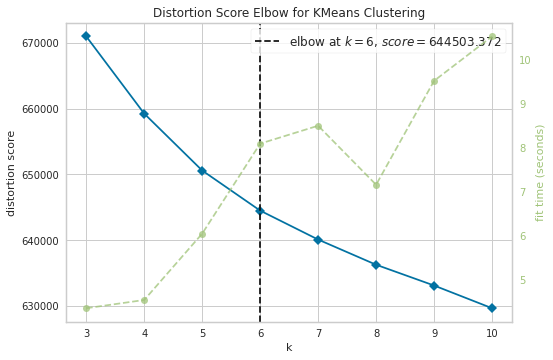

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=range(3,11, 1))

visualizer.fit(user_artist_matrix)
best_k = visualizer.elbow_value_
visualizer.show()

In [32]:
k_means_est = KMeans(n_clusters=6, random_state=100)

k_means_est.fit(user_artist_matrix)

KMeans(n_clusters=6, random_state=100)

In [33]:
cluster_labels = k_means_est.labels_

user_clusters = user_artist_matrix.reset_index()[['user_id']]

user_clusters['cluster'] = cluster_labels + 1

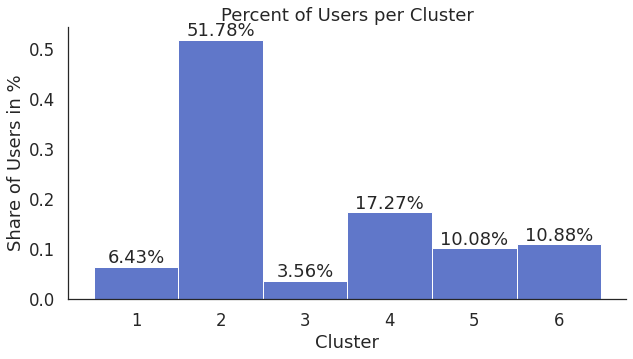

In [34]:
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(10,5))    

sns.histplot(data=user_clusters, 
             x="cluster",
             color='#2b4ab8',
             stat="probability",
             discrete=True
            )

sns.despine()
sns.set(font_scale = 1.5)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2%'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
                   
ax.set_title('Percent of Users per Cluster', fontsize=18)
ax.set_xlabel('Cluster', fontsize=18)
ax.set_ylabel('Share of Users in %', fontsize=18)
_ = ax.legend([],[], frameon=False)

In [50]:
def plot_wordcloud_from_ranking(ranking_dict, max_words=10, plot_title=''):
    
    wc = WordCloud(background_color="white", 
                   max_words=max_words,
                   random_state=1,
                   colormap='gnuplot',
                    )
    wc.generate_from_frequencies(ranking_dict)
    
    plt.title(plot_title, fontsize = 50)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

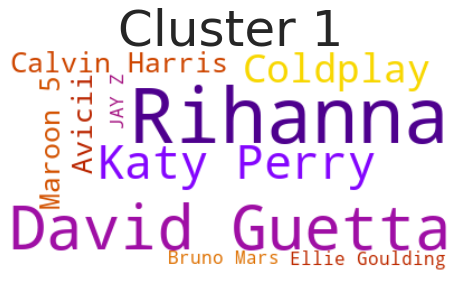

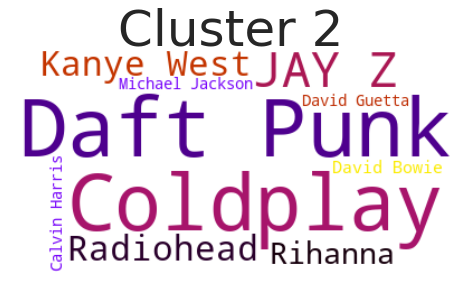

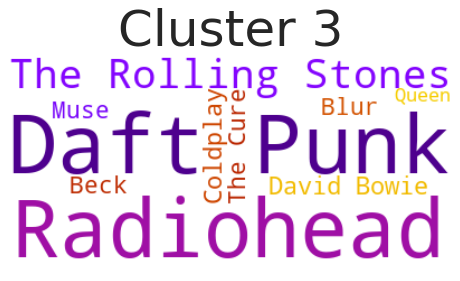

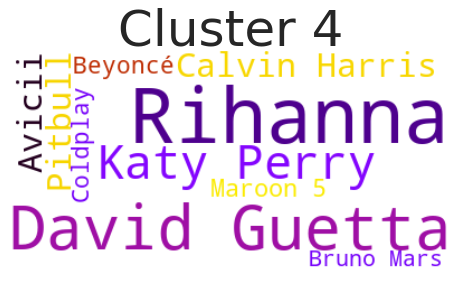

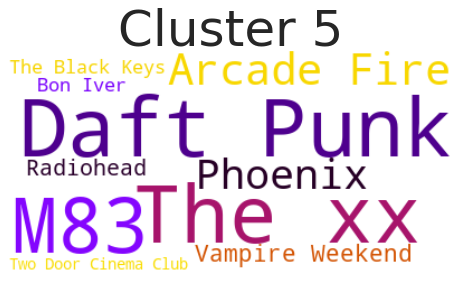

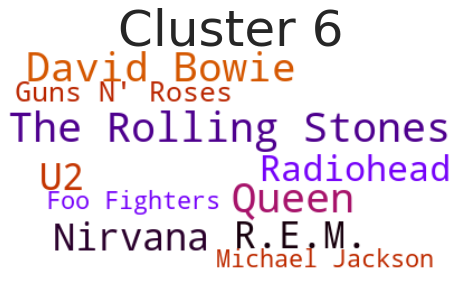

In [51]:
artist_popularity = pd.DataFrame(user_artist_matrix.sum() / user_artist_matrix.to_numpy().sum(), columns=['total_popularity']).reset_index().iloc[:, 1:]

for c in sorted(user_clusters.cluster.unique()):
    uids = user_clusters.loc[user_clusters.cluster == c, 'user_id']
    cluster_user = user_artist_matrix.loc[list(user_artist_matrix.reset_index().user_id.isin(uids))]
    
    new_col_name = 'cluster'+str(c)+'_popularity'
    cluster_popularity = pd.DataFrame(cluster_user.sum() / cluster_user.to_numpy().sum(), columns=[new_col_name]).reset_index().iloc[:, 1:]
   
    cluster_popularity_dict = cluster_popularity.set_index('artistname').to_dict()[new_col_name]
    plot_wordcloud_from_ranking(cluster_popularity_dict, plot_title="Cluster " + str(c))
    print()
    
    artist_popularity = pd.merge(artist_popularity, cluster_popularity, how='inner', on='artistname')